# Analysis: Crowd Sensitivity ("Cynical" vs "FOMO" interpretations)

As the value goes up, the agent makes less and less bet. There might be two explanations for that :
1) The **"Cynical Detective"** : the agent has associated high gains with low probabilities.
2) The **"FOMO"** : the agent wants to follow the crowd. Even if the outsider has great value, the agent doesn't want to bet against the opponents, to avoid falling back.

To verify these two hypothesis, we will create 2 heatmaps with different opponent repartitions to see its impact on the agent betting strategy.


Scanning normal crowd...
Scanning inverted crowd...


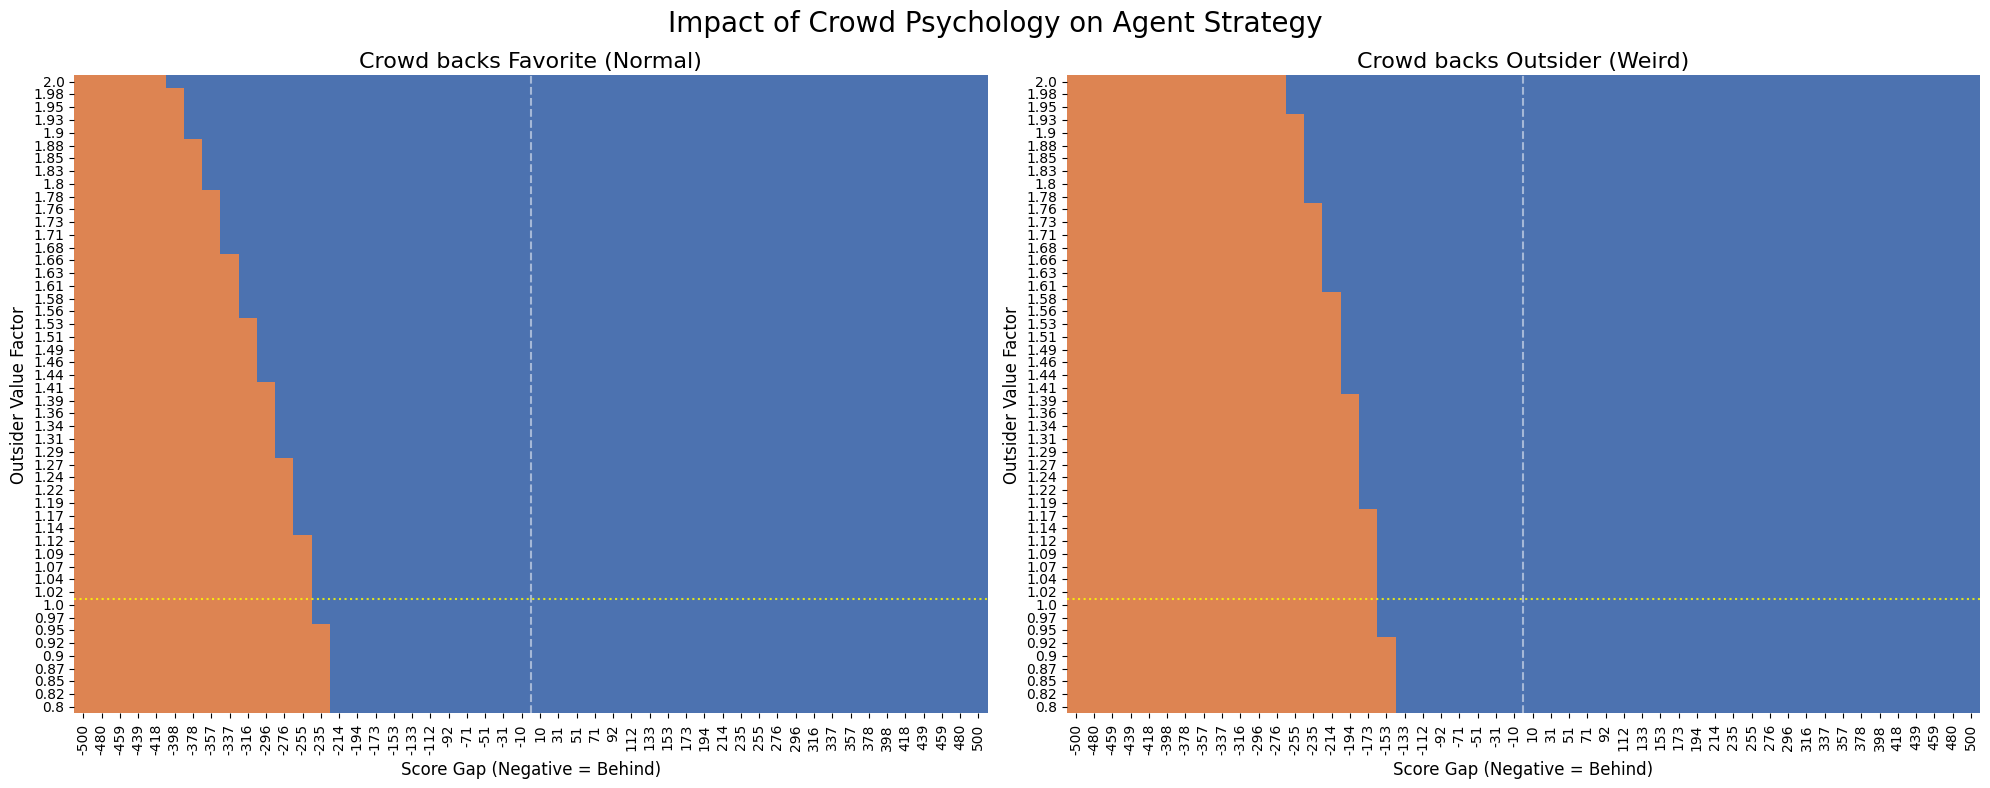

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from stable_baselines3 import PPO
from matplotlib.colors import ListedColormap
import os
import sys
import torch

# Add project root to path to import core logic
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from mpp_project.core import get_observation
from mpp_project.match_simulator import generate_opponent_repartition

# --- CONFIGURATION ---
# Point to your best V3 model
MODEL_PATH = "../models_v3/ppo_v3_phase4_domain_rand.zip" 
model = PPO.load(MODEL_PATH)

def get_observation_with_custom_repart(gap, val_factor, repart_mode="normal"):
    """
    Generates an observation with a specific Crowd Behavior.
    
    repart_mode:
      - 'normal': Crowd herds on the Favorite (Standard Power Law).
      - 'inverted': Crowd herds on the Outsider (Inverse Power Law).
    """
    # 1. Fixed Probabilities (Uncertain Match)
    # Order: Fav, Draw, Out
    p_fav = 0.45
    p_draw = 0.30
    p_out = 0.25
    probas = np.array([p_fav, p_draw, p_out])
    
    # 2. Gains (Authentic Formula + Value Injection)
    ev_avg = 35.0
    p_clipped = np.maximum(probas, 0.001)
    ev_factor = -2.54 * (p_clipped**2) + 3.14 * p_clipped + 0.21
    gains = (ev_factor * ev_avg) / p_clipped
    
    # Inject Value on Outsider (The variable we scan)
    gains[2] *= val_factor

    # 3. Repartition (THE EXPERIMENTAL VARIABLE)
    if repart_mode == "normal":
        # Standard Power Law (Gamma=2.0) -> Crowd backs Favorite
        repart = generate_opponent_repartition(np.expand_dims(probas, 0), gamma=2.0)[0]
    elif repart_mode == "inverted":
        # Inverted: Crowd loves the Outsider! 
        # We flip the probas before generating repartition to simulate "Inverse Herding"
        # Or we can just manually set it to favor index 2.
        # Let's manually construct a "Crowd loves Outsider" vector
        # Normal [0.6, 0.3, 0.1] -> Inverted [0.1, 0.3, 0.6]
        normal_repart = generate_opponent_repartition(np.expand_dims(probas, 0), gamma=2.0)[0]
        repart = normal_repart[::-1] # Flip it: Fav gets low bets, Out gets high bets

    # 4. Scores & Context (Last Match)
    scores = np.zeros(12)
    scores[0] = 1000.0
    scores[1] = 1000.0 - gap
    scores[2:] = 900.0
    
    matches_rem = 1
    total_matches = 51
    fraction = matches_rem / total_matches
    future_max = np.max(gains) * matches_rem

    # 5. Build
    obs, sort_idx = get_observation(
        probas, gains, repart, scores, 0, 
        future_max, fraction, ev_avg
    )
    return obs, sort_idx

# --- SCANNING ---
gaps = np.linspace(-500, 500, 50)
value_factors = np.linspace(0.8, 2.0, 50)

modes = ["normal", "inverted"]
maps = {}

for mode in modes:
    print(f"Scanning {mode} crowd...")
    policy_map = np.zeros((len(value_factors), len(gaps)))
    
    for i, val in enumerate(value_factors):
        for j, gap in enumerate(gaps):
            obs, sort_idx = get_observation_with_custom_repart(gap, val, mode)
            action, _ = model.predict(obs, deterministic=True)
            policy_map[i, j] = sort_idx[action] # Map to real index
            
    maps[mode] = policy_map

# --- PLOTTING ---
fig, axes = plt.subplots(1, 2, figsize=(20, 8))
cmap = ListedColormap(['#4c72b0', '#dd8452', '#c44e52']) # Blue=Fav, Org=Dr, Red=Out

titles = {
    "normal": "Crowd backs Favorite (Normal)",
    "inverted": "Crowd backs Outsider (Weird)"
}

for ax, mode in zip(axes, modes):
    sns.heatmap(maps[mode], 
                xticklabels=np.round(gaps).astype(int), 
                yticklabels=np.round(value_factors, 2),
                cmap=cmap, vmin=0, vmax=2,
                cbar=False, ax=ax)
    
    ax.invert_yaxis()
    ax.set_title(titles[mode], fontsize=16)
    ax.set_xlabel("Score Gap (Negative = Behind)", fontsize=12)
    ax.set_ylabel("Outsider Value Factor", fontsize=12)
    
    # Guides
    ax.axvline(x=len(gaps)//2, color='white', linestyle='--', alpha=0.5)
    ax.axhline(y=np.searchsorted(value_factors, 1.0), color='yellow', linestyle=':', alpha=0.8)

plt.suptitle("Impact of Crowd Psychology on Agent Strategy", fontsize=20)
plt.tight_layout()
plt.show()

## Game Theory & Crowd Independence

The comparison between "Normal" (Herding on Favorite) and "Inverted" (Herding on Outsider) crowd behaviors reveals that the agent is **primarily driven by Odds and Gains**, rather than crowd psychology.

The minor differences in the heatmaps suggest the agent is aware of the crowd (likely for tie-breaking or slight blocking adjustments), but it does not blindly follow or fade the public.

This reinforces the **"Cynical Detective"** profile: the agent trusts its own internal valuation of Risk vs. Reward above social signals, which is a robust trait for a general-purpose tournament bot.